In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')
import tokamakTK

import pydotplus
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "../../data/"
fig_path = "../../../../LATEX/Latex Images/"
plt.rc('font',family = 'serif')


In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# REMOVING SPHERICAL TOKAMAKS
#DB5 = DB5[~DB5.TOK.isin(['MAST', 'NSTX', 'START'])]


# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


In [4]:
features = ['WFICFORM', 'WFFORM', 'RHOSTAR', 'ZEFFNEO', 'DWDIA', 'BETASTAR', 'NUSTAR', 'PFLOSS','Q95']

In [5]:
DB5 = tokamakTK.clean_categorical_data(DB5)

# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()

data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

# Notice that for trees, it is not necessary to scale the features, but can improve the performance
"""
    It's a good practice to consider feature scaling as part of the overall data 
    preprocessing pipeline, especially if there are specific considerations 
    or requirements in your analysis.
"""
data_num = tokamakTK.clean_numerical_data(data_num, SS_scaling=False, UL_scale=True)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1
                 )

In [6]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [7]:
rf = RandomForestClassifier(min_samples_split=2,  
                            min_samples_leaf=1,
                            min_impurity_decrease=0.0007,
                            n_estimators = 90,
                            max_depth = 23,
                            criterion='entropy',
                            max_features=None,
                            n_jobs=-1,
                            random_state=71
                           )

In [8]:
rf.fit(X_train, y_train)
y_pred= rf.predict_proba(X_test)

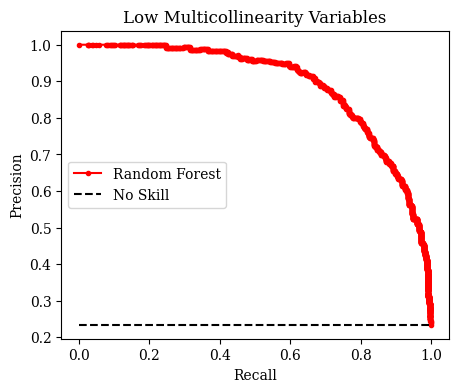

In [9]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Low Multicollinearity Variables")
plt.legend();

In [10]:
y_pred_ = rf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.83042394, 0.92745763]),
 array([0.75681818, 0.95264624]),
 array([0.79191439, 0.9398832 ]),
 array([ 440, 1436]))

# SHAP Values 

In [11]:
import shap
import seaborn as sns

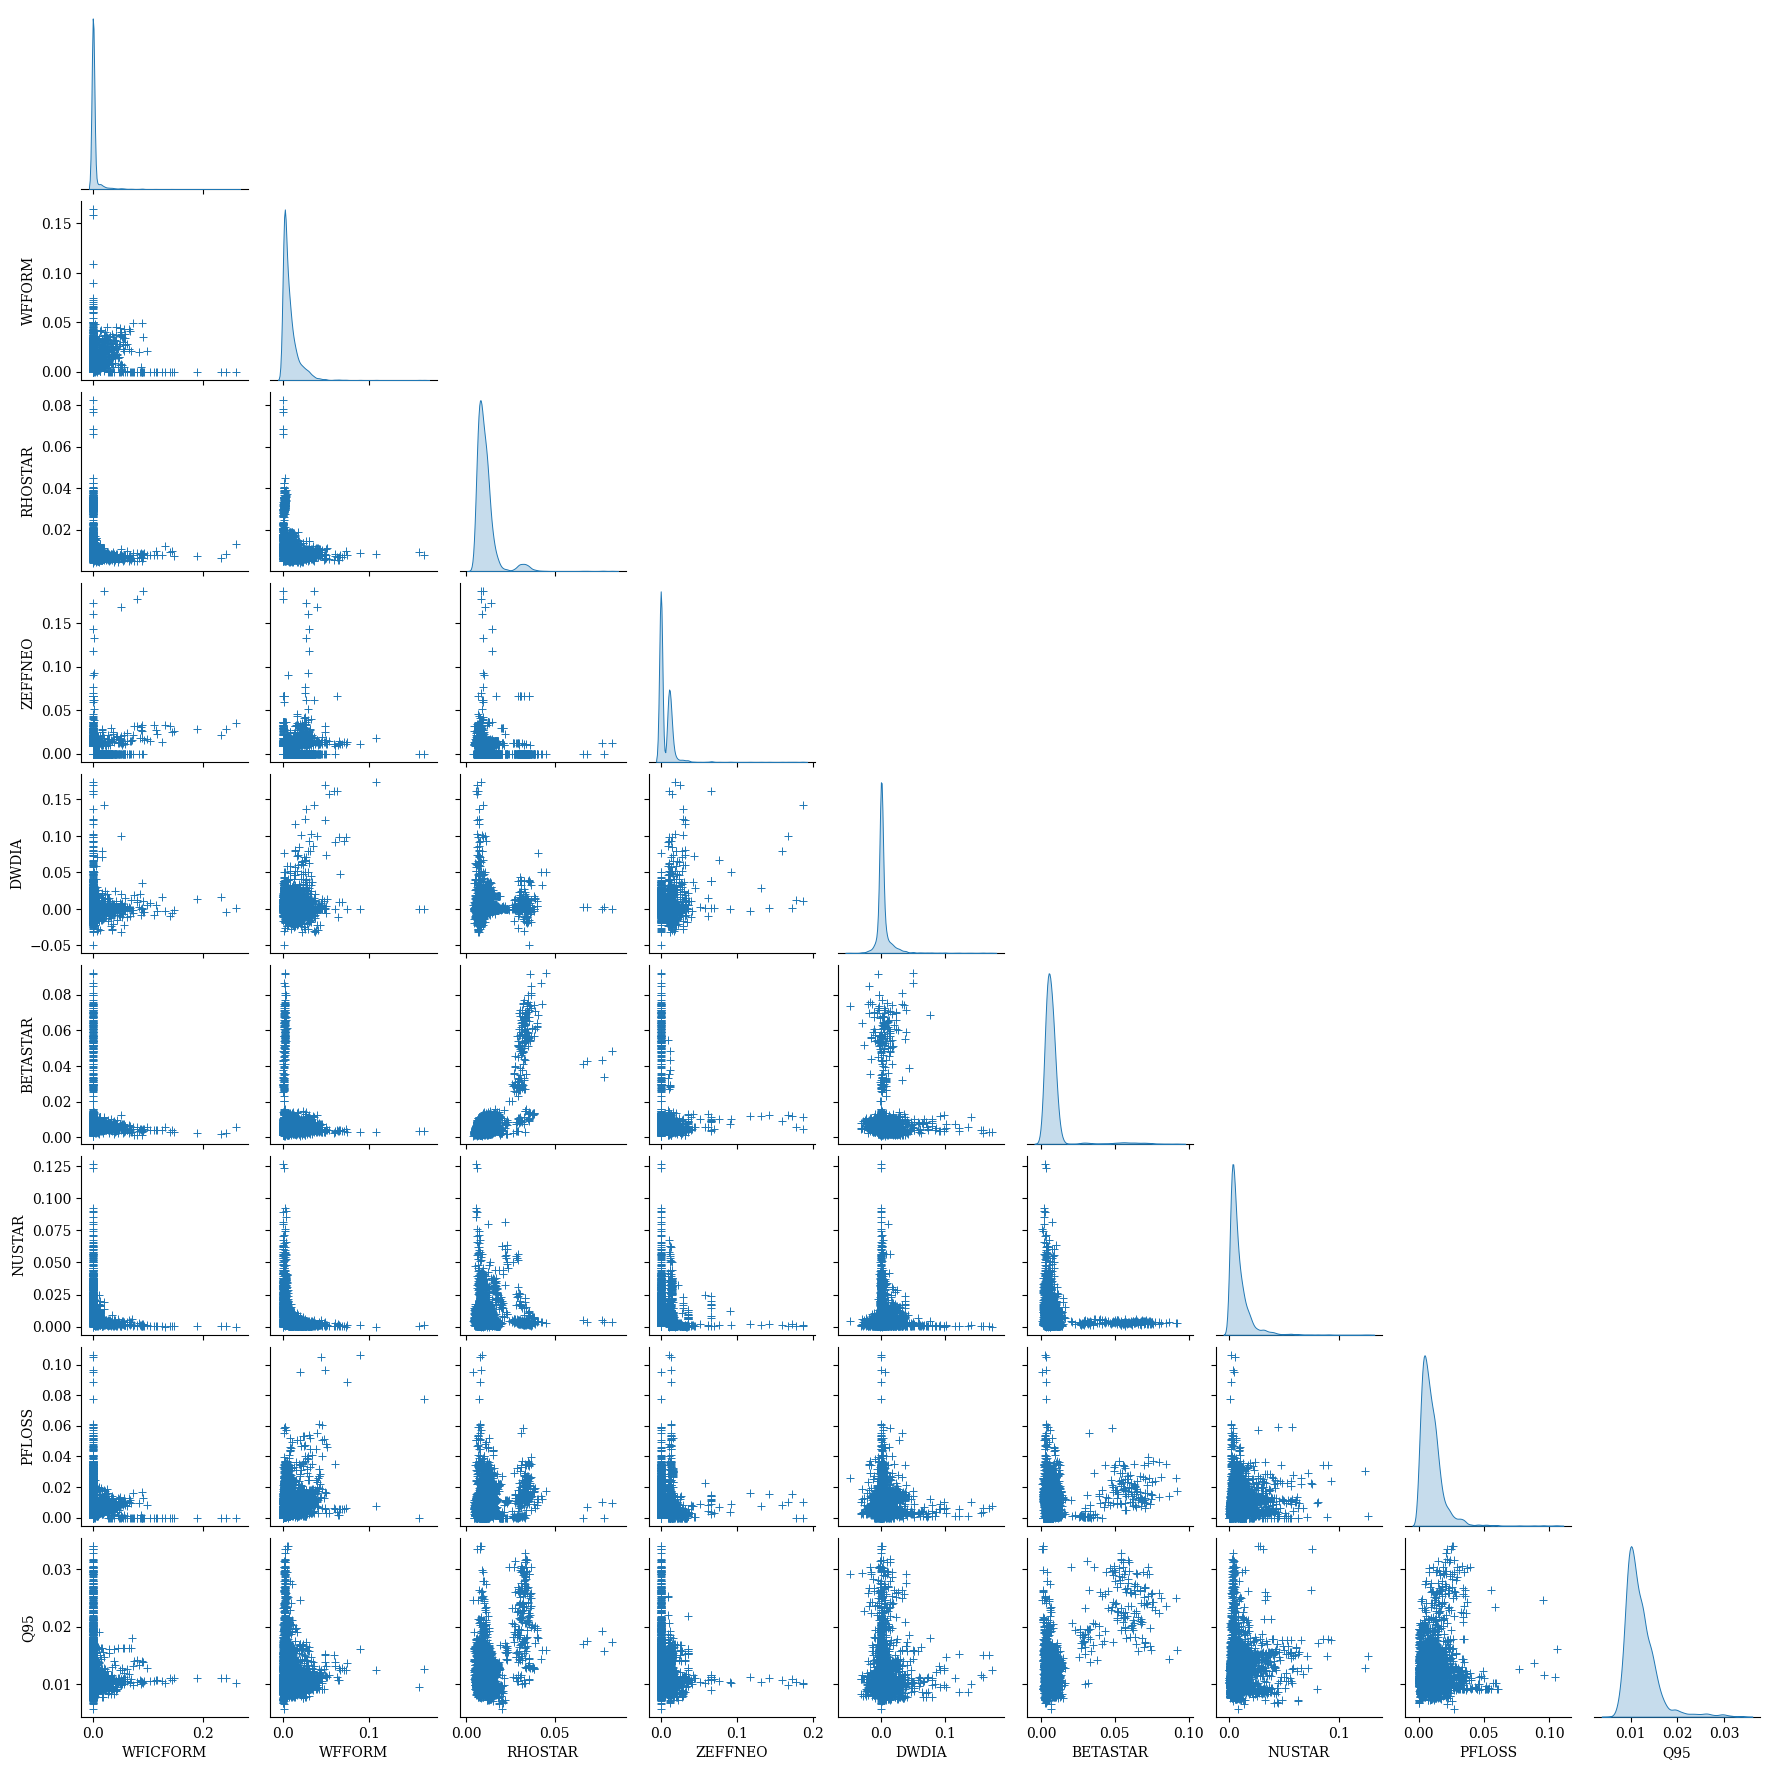

In [13]:
grid_max = sns.pairplot(X_train,
                        plot_kws=dict(linewidth=0.7),
                        diag_kind='kde',height=2,corner=True,markers="+",
                        diag_kws=dict(linewidth=0.7));
grid_maxg.set_size_inches(15,15);

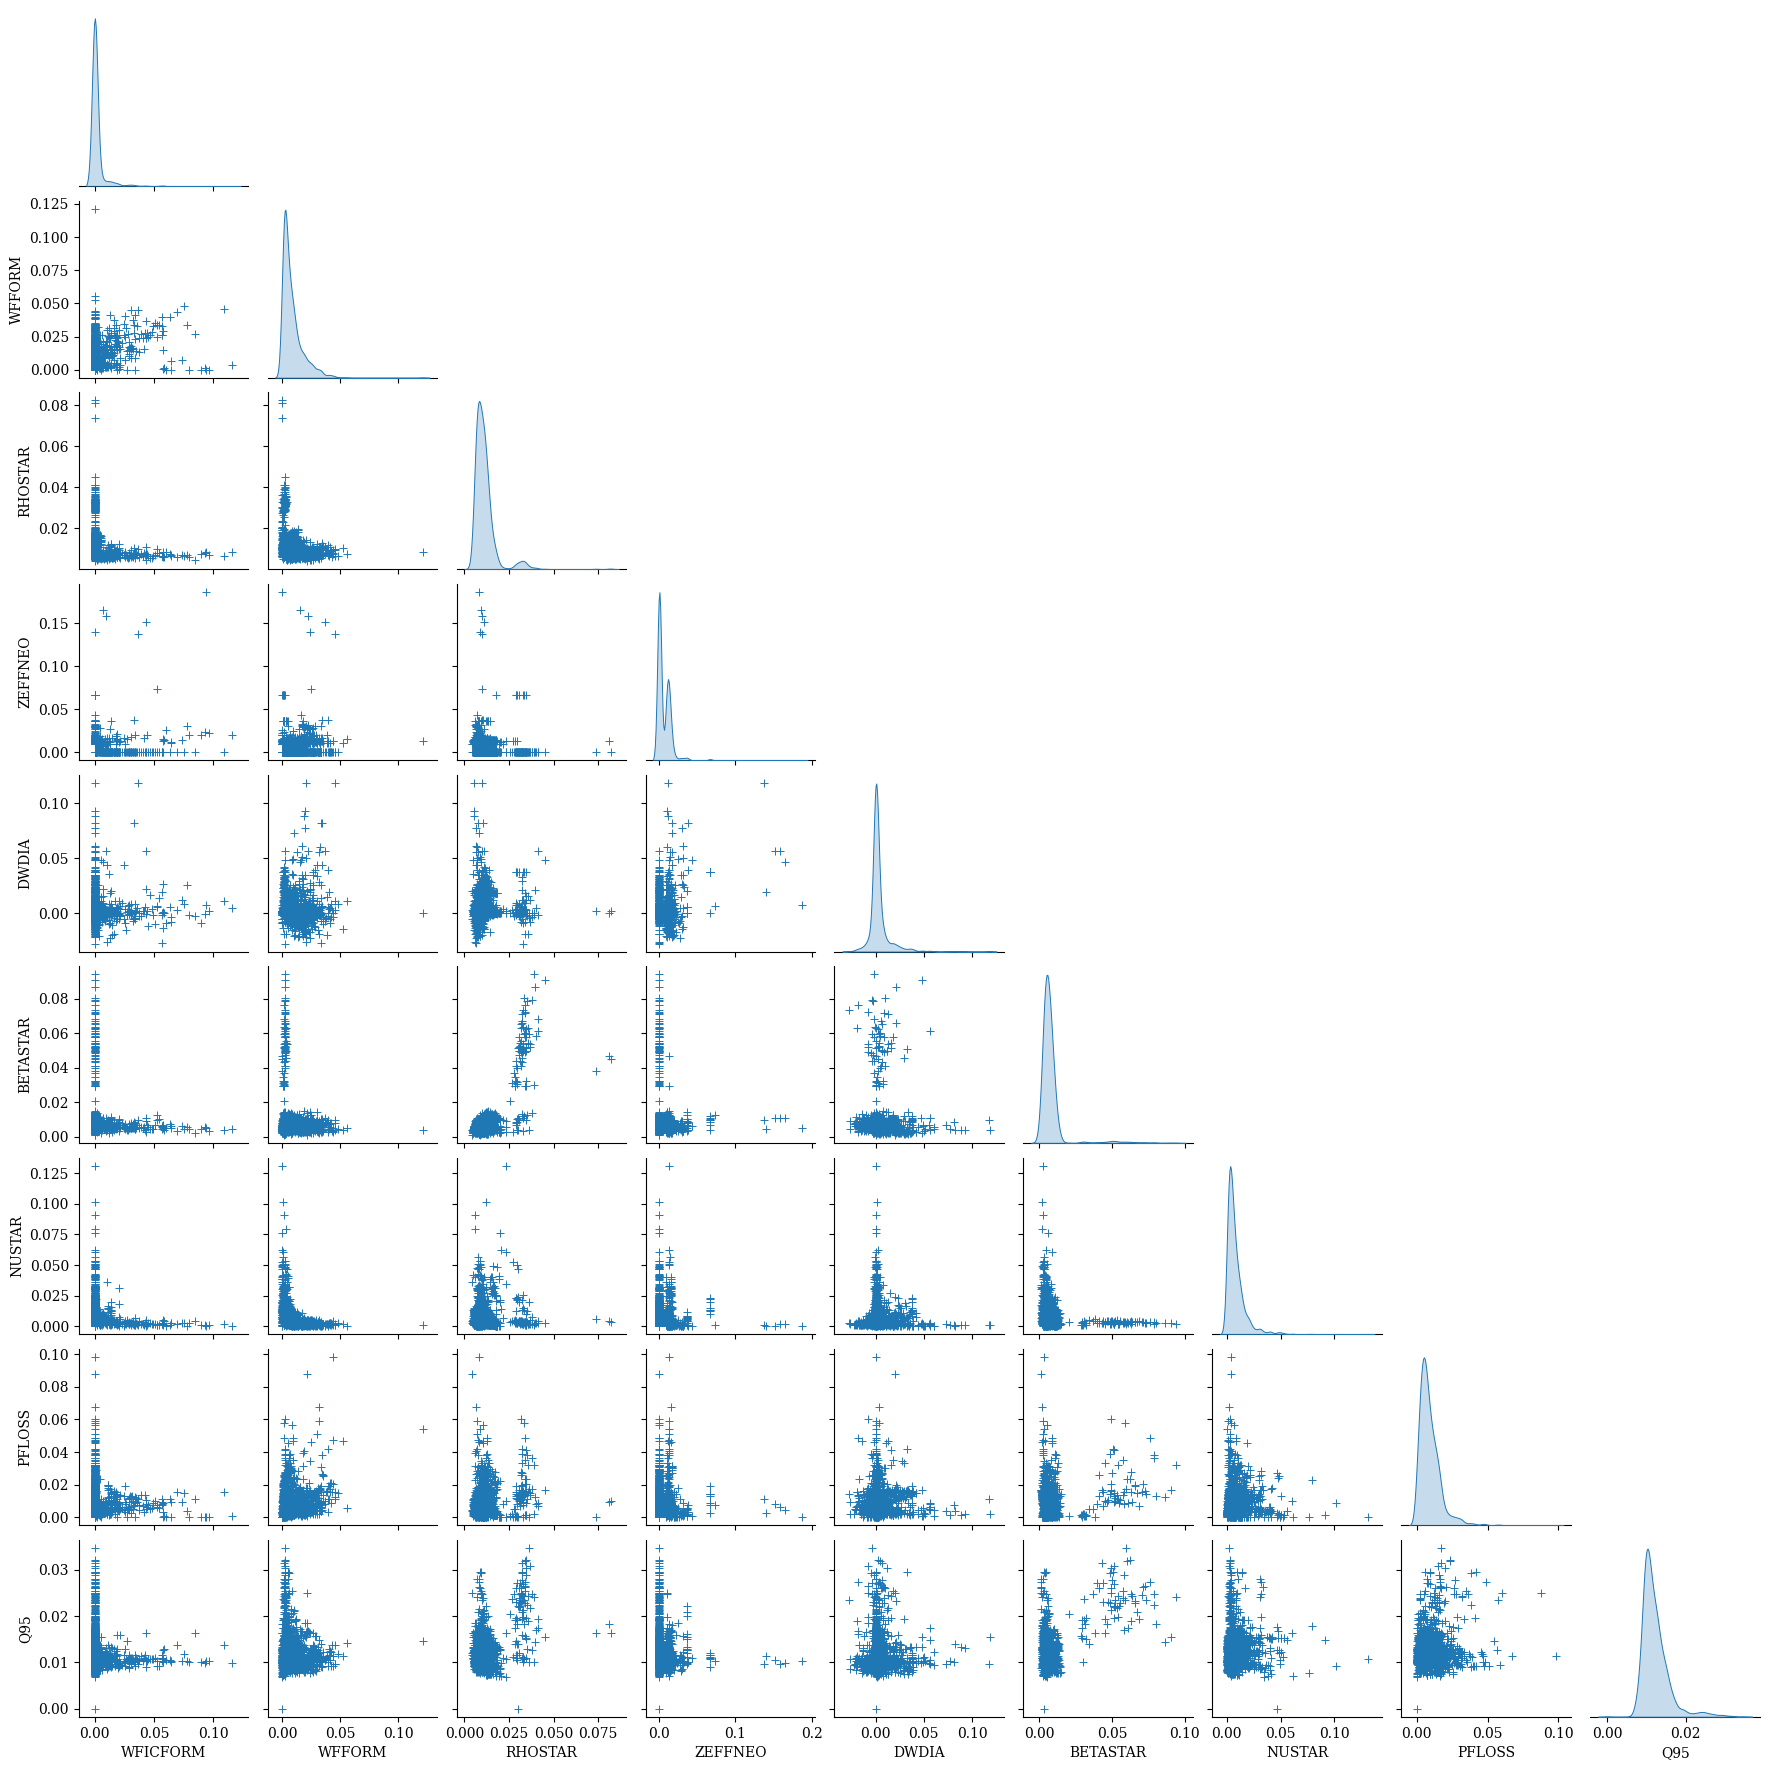

In [18]:
grid_max_test = sns.pairplot(X_test,
                        plot_kws=dict(linewidth=0.7),
                        diag_kind='kde',height=2,corner=True,markers="+",
                        diag_kws=dict(linewidth=0.7));

In [19]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(rf)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (9, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.